# Valorant VCT Predictions

## Backstory
The first file I was able to create a model that can predict with up to 65% accuracy. Since then I learned quite a bit about data analytics and figured it would be easier to start fresh when training my next models.

Goal for this file is to get up to 70% accuracy and I will try to update the existing logistic regression model and explore different models, such as XGBoost

# Next Steps
Graphs are not looking as promising as earlier, I think what needs to be done next is to 
* greatly reduce the scope of the data
* Only look at a few teams
* make moving averages for each maps and make predictions on a map by map basis

The data leakage was a bit of a set back, but glad to have found it. Just need to be a bit more weary for the future.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

#get dataframes for each map and try looking for correlations/signals that can be used for each map
data = pd.read_csv('scrapy/vlrgg/playerData/vlr.csv')
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, "%d-%m-%y"))
data['playerHS'] = data['playerHS'].apply(lambda x: float(str(x).split('%')[0]))

In [2]:
#analysis for the map haven
num_cols =['playerKills',
       'playerDeaths', 'playerAssists', 'playerACS', 'playerADR', 'playerHS',
       'playerFirstBlood', 'playerFirstDeath']

haven_data = data

haven_data[num_cols] = haven_data.sort_values(by=['date', 'playerName']).groupby(['playerName'])[num_cols].rolling(5).mean().shift(1).reset_index(level=0, drop=True)

haven_data_avg = haven_data.copy()

In [3]:
haven_total = haven_data_avg.copy()
haven_total[num_cols] = haven_total.groupby(['gameID', 'playerTeam'])[num_cols].transform('sum')
haven_total = haven_total.drop_duplicates(subset=['gameID', 'playerTeam']).dropna()
haven_team_total = pd.DataFrame()
for games in haven_total['gameID'].unique():
    teams = haven_total[haven_total['gameID']==games]['playerTeam'].unique()
    matchData = haven_total[haven_total['gameID']==games]
    if len(teams)!=2:
        continue
    team1 = matchData[matchData['playerTeam']==teams[0]]
    team2 = matchData[matchData['playerTeam']==teams[1]]
    tempDict = {
           'playerTeam': teams[0],
           'map': team1['map'].values[0],
           'playerKills': team1['playerKills'].values[0],
           'playerDeaths': team1['playerDeaths'].values[0],
           'playerAssists': team1['playerAssists'].values[0],
           'playerACS': team1['playerACS'].values[0],
           'playerHS': team1['playerHS'].values[0],
           'playerADR': team1['playerADR'].values[0],
           'playerFirstBlood': team1['playerFirstBlood'].values[0],
           'playerFirstDeath': team1['playerFirstDeath'].values[0],
           'o_playerKills': team2['playerKills'].values[0],
           'o_playerDeaths': team2['playerDeaths'].values[0],
           'o_playerAssists': team2['playerAssists'].values[0],
           'o_playerACS': team2['playerACS'].values[0],
           'o_playerHS': team2['playerHS'].values[0],
           'o_playerADR': team2['playerADR'].values[0],
           'o_playerFirstBlood': team2['playerFirstBlood'].values[0],
           'o_playerFirstDeath': team2['playerFirstDeath'].values[0],
           'o_playerTeam': teams[1],
           'result': team1['result'].values[0]
    }
    haven_team_total = haven_team_total.append(tempDict, ignore_index=True)
haven_team_total.to_csv('teamMovingAvg.csv')

<AxesSubplot:xlabel='playerDeaths', ylabel='o_playerDeaths'>

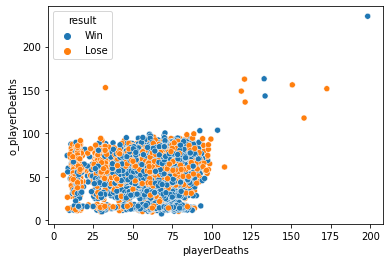

In [4]:
#making a bunch of transformations and seeing whether there is a separation of data 
haven_team_total = haven_team_total.replace(0, np.nan)
haven_team_total = haven_team_total.dropna()
haven_team_total['kdRatio'] = haven_team_total.apply(lambda x: x['playerKills']/x['playerDeaths'], axis=1)
haven_team_total['o_kdRatio'] = haven_team_total.apply(lambda x: x['o_playerKills']/x['o_playerDeaths'], axis=1)
haven_team_total['fb_diff'] = haven_team_total.apply(lambda x: x['playerFirstBlood'] - x['playerFirstDeath'], axis=1)
haven_team_total['o_fb_diff'] = haven_team_total.apply(lambda x: x['o_playerFirstBlood'] - x['o_playerFirstDeath'], axis=1)
sns.scatterplot(data=haven_team_total, x='playerDeaths', y='o_playerDeaths', hue='result')

In [5]:
haven_team_total.columns

Index(['map', 'o_playerACS', 'o_playerADR', 'o_playerAssists',
       'o_playerDeaths', 'o_playerFirstBlood', 'o_playerFirstDeath',
       'o_playerHS', 'o_playerKills', 'o_playerTeam', 'playerACS', 'playerADR',
       'playerAssists', 'playerDeaths', 'playerFirstBlood', 'playerFirstDeath',
       'playerHS', 'playerKills', 'playerTeam', 'result', 'kdRatio',
       'o_kdRatio', 'fb_diff', 'o_fb_diff'],
      dtype='object')

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

cat_col = ['playerTeam', 'o_playerTeam', 'result', 'map']
num_cols =['o_playerACS', 'o_playerADR','playerACS', 'playerADR','kdRatio',
'o_kdRatio', 'fb_diff', 'o_fb_diff', 'playerKills', 'o_playerKills','playerDeaths', 'o_playerDeaths']
modeldf = pd.get_dummies(haven_team_total[cat_col])
modeldf[num_cols] = haven_team_total[num_cols]

X_train, X_test, y_train, y_test = train_test_split(modeldf.drop(['result_Lose', 'result_Win'], axis=1), modeldf['result_Win'], test_size=0.25,random_state=123)
clf = LogisticRegression(random_state=13, max_iter=10000)
clf.fit(X_train, y_train)
print(confusion_matrix(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

[[ 638  489]
 [ 386 1155]]
0.6720389805097451


# Using XGBoost
Using the XGBoost model to make predictions

In [72]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt


In [73]:
df = pd.read_csv('teamMovingAvg.csv')
df.head()

,Unnamed: 0,map,o_playerACS,o_playerADR,o_playerAssists,o_playerDeaths,o_playerFirstBlood,o_playerFirstDeath,o_playerHS,o_playerKills,...,playerACS,playerADR,playerAssists,playerDeaths,playerFirstBlood,playerFirstDeath,playerHS,playerKills,playerTeam,result
0,0,Haven,1068.4,713.0,32.2,84.8,13.2,11.0,107.0,89.4,...,968.4,665.2,30.2,65.4,10.4,9.8,134.0,69.0,VS,Win
1,1,Haven,1039.2,646.8,28.4,64.0,11.8,8.4,115.8,73.8,...,1117.8,712.4,35.6,57.2,11.4,8.4,111.2,77.8,KRÜ,Win
2,2,Breeze,1048.6,712.2,32.4,83.0,13.2,10.2,111.6,85.6,...,977.4,679.6,28.4,65.6,9.8,9.4,142.4,68.2,VS,Win
3,3,Breeze,979.8,654.0,32.4,77.0,11.8,11.2,142.6,80.0,...,1068.8,686.4,29.2,66.4,11.8,8.4,133.8,78.8,ACE,Lose
4,4,Ascent,1055.6,682.0,34.2,80.8,11.6,12.4,93.6,86.0,...,1079.4,676.4,31.2,68.0,11.0,10.4,107.0,80.0,VKS,Win


In [74]:
df['playerTeam'].replace(' ',  '_', regex=True, inplace=True)
df['playerTeam'].replace(',',  '', regex=True, inplace=True)
df['playerTeam'].replace('\[',  '', regex=True, inplace=True)
df['playerTeam'].replace('\]',  '', regex=True, inplace=True)
df['playerTeam'].replace('<',  '', regex=True, inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()


,map,o_playerACS,o_playerADR,o_playerAssists,o_playerDeaths,o_playerFirstBlood,o_playerFirstDeath,o_playerHS,o_playerKills,o_playerTeam,playerACS,playerADR,playerAssists,playerDeaths,playerFirstBlood,playerFirstDeath,playerHS,playerKills,playerTeam,result
0,Haven,1068.4,713.0,32.2,84.8,13.2,11.0,107.0,89.4,FS,968.4,665.2,30.2,65.4,10.4,9.8,134.0,69.0,VS,Win
1,Haven,1039.2,646.8,28.4,64.0,11.8,8.4,115.8,73.8,INF,1117.8,712.4,35.6,57.2,11.4,8.4,111.2,77.8,KRÜ,Win
2,Breeze,1048.6,712.2,32.4,83.0,13.2,10.2,111.6,85.6,FS,977.4,679.6,28.4,65.6,9.8,9.4,142.4,68.2,VS,Win
3,Breeze,979.8,654.0,32.4,77.0,11.8,11.2,142.6,80.0,GMB,1068.8,686.4,29.2,66.4,11.8,8.4,133.8,78.8,ACE,Lose
4,Ascent,1055.6,682.0,34.2,80.8,11.6,12.4,93.6,86.0,X10C,1079.4,676.4,31.2,68.0,11.0,10.4,107.0,80.0,VKS,Win


In [75]:
X = df.drop('result', axis=1).copy()
y = df['result'].copy()

In [76]:
X.columns[X.columns.str.contains("[\[\]<]")]

Index([], dtype='object')

In [80]:
X_encoded = pd.get_dummies(X)
y_encoded = pd.get_dummies(y).drop('Lose', axis=1)
X_encoded.columns = X_encoded.columns.str.replace("[\[\]]", "_")
X_encoded.columns[X_encoded.columns.str.contains("[\[\]<]")]

<ipython-input-80-12b5999fe98b>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  X_encoded.columns = X_encoded.columns.str.replace("[\[\]]", "_")


Index([], dtype='object')

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, stratify=y)

In [91]:
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)]
)

[0]	validation_0-aucpr:0.74945
[1]	validation_0-aucpr:0.75879
[2]	validation_0-aucpr:0.76227
[3]	validation_0-aucpr:0.76683
[4]	validation_0-aucpr:0.76781
[5]	validation_0-aucpr:0.76823
[6]	validation_0-aucpr:0.76816
[7]	validation_0-aucpr:0.76789
[8]	validation_0-aucpr:0.76844
[9]	validation_0-aucpr:0.76843
[10]	validation_0-aucpr:0.76913
[11]	validation_0-aucpr:0.76736
[12]	validation_0-aucpr:0.76880
[13]	validation_0-aucpr:0.76996
[14]	validation_0-aucpr:0.77033
[15]	validation_0-aucpr:0.77107
[16]	validation_0-aucpr:0.77078
[17]	validation_0-aucpr:0.77067
[18]	validation_0-aucpr:0.77143
[19]	validation_0-aucpr:0.77162
[20]	validation_0-aucpr:0.77230
[21]	validation_0-aucpr:0.77255
[22]	validation_0-aucpr:0.77325
[23]	validation_0-aucpr:0.77289
[24]	validation_0-aucpr:0.77337
[25]	validation_0-aucpr:0.77272
[26]	validation_0-aucpr:0.77261
[27]	validation_0-aucpr:0.77306
[28]	validation_0-aucpr:0.77220
[29]	validation_0-aucpr:0.77261
[30]	validation_0-aucpr:0.77245
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

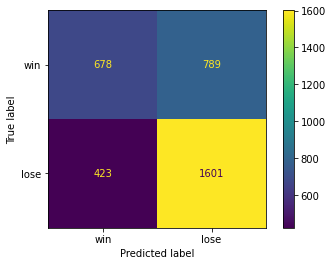

In [92]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', display_labels=['win', 'lose'])

In [94]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0,0.25,1.0],
    'reg_lambda': [0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}
gs = GridSearchCV(estimator=clf_xgb ,param_grid=param_grid, verbose=0, scoring='roc_auc', n_jobs=10, cv=3)
gs.fit(X_train, y_train)
gs.best_params_

KeyboardInterrupt: 